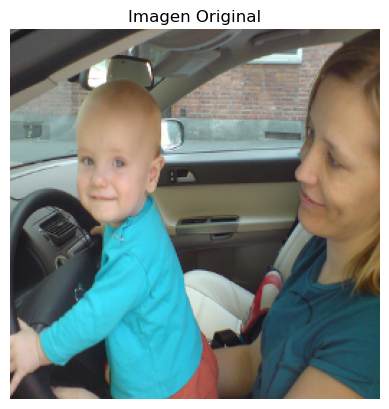

[ WARN:0@501.953] global loadsave.cpp:248 findDecoder imread_('ESCOGIDAS/Annotations/2011_003255.png'): can't open/read file: check file path/integrity


AttributeError: 'NoneType' object has no attribute 'astype'

In [3]:
import os
import cv2
import numpy as np
import random
from matplotlib import pyplot as plt
from xml.etree import ElementTree as ET
import tensorflow as tf

# Rutas a las carpetas del conjunto de datos Pascal VOC 2012
image_folder = 'ESCOGIDAS/JPEGImages'
segmentation_folder = 'ESCOGIDAS/Annotations'
annotations_folder = 'ESCOGIDAS/Annotations'

# Obtener la lista de archivos en la carpeta de imágenes
image_files = os.listdir(image_folder)

# Seleccionar aleatoriamente 1 imagen
selected_image = random.choice(image_files)

# Función para cargar y mostrar una imagen con tamaño de 257x257
def load_and_display_image(image_path, size=(257, 257)):
    img = cv2.imread(os.path.join(image_folder, image_path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, size)
    plt.imshow(img)
    plt.title('Imagen Original')
    plt.axis('off')
    plt.show()
    return img

# Función para cargar la máscara de segmentación
def load_segmentation_mask(image_path):
    mask_path = os.path.join(segmentation_folder, image_path.replace('.jpg', '.png'))
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    return mask

# Función para cargar las anotaciones XML y obtener las clases de objetos
def load_annotations(image_path):
    annotation_path = os.path.join(annotations_folder, image_path.replace('.jpg', '.xml'))
    tree = ET.parse(annotation_path)
    root = tree.getroot()
    classes = [obj.find('name').text for obj in root.findall('.//object')]
    return classes

# Función para aplicar la máscara de segmentación a la imagen
def apply_segmentation_mask(img, mask):
    # Normalizar la máscara para obtener solo valores binarios (0 o 255)
    _, binary_mask = cv2.threshold(mask.astype(np.uint8), 0, 255, cv2.THRESH_BINARY)
    
    # Asegurarse de que la máscara tenga el mismo tamaño que la imagen original
    binary_mask = cv2.resize(binary_mask, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST)
    
    # Aplicar la máscara a la imagen
    segmented_img = cv2.bitwise_and(img, img, mask=binary_mask)
    return segmented_img


# Cargar el modelo DeepLab 
model = tf.keras.applications.DenseNet201(weights='imagenet', input_shape=(None, None, 3), include_top=False)

# Ejemplo de uso
original_img = load_and_display_image(selected_image, size=(257, 257))
segmentation_mask = load_segmentation_mask(selected_image)
annotations = load_annotations(selected_image)

# Aplicar la máscara de segmentación a la imagen
segmented_img = apply_segmentation_mask(original_img, segmentation_mask)

# Visualizar la imagen transformada
plt.imshow(segmented_img)
plt.title('Imagen Transformada')
plt.axis('off')
plt.show()

# Imprimir las clases de objetos presentes en la imagen
print('Clases de objetos presentes:')
for obj_class in annotations:
    print('- ' + obj_class)

# Función para mover la imagen hacia arriba
def move_up(img):
    rows, cols, _ = img.shape
    M = np.float32([[1, 0, 0], [0, 1, -rows//4]])
    return cv2.warpAffine(img, M, (cols, rows))

# Función para mover la imagen hacia abajo
def move_down(img):
    rows, cols, _ = img.shape
    M = np.float32([[1, 0, 0], [0, 1, rows//4]])
    return cv2.warpAffine(img, M, (cols, rows))

# Aplicar las transformaciones y mostrar las imágenes resultantes
transformations = [move_up, move_down]

for transform_func in transformations:
    transformed_img = transform_func(original_img)

    # Visualizar la imagen transformada
    plt.imshow(transformed_img)
    plt.title('Imagen Transformada')
    plt.axis('off')
    plt.show()

    # Identificar objetos en la imagen transformada
    transformed_annotations = load_annotations(selected_image)
    print('Clases de objetos presentes en la imagen transformada:')
    for obj_class in transformed_annotations:
        print('- ' + obj_class)
